In [43]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*2
presets = 'best_quality'

do_drop_ds = True
# hour, dayofweek, dayofmonth, month, year
use_dt_attrs = []#["hour", "year"]
use_estimated_diff_attr = False
use_is_estimated_attr = True

use_groups = False
n_groups = 8

auto_stack = True
num_stack_levels = 1
num_bag_folds = 0
if auto_stack:
    num_stack_levels = None
    num_bag_folds = None

use_tune_data = False
use_test_data = True
tune_and_test_length = 24*30*3 # 3 months from end
holdout_frac = None
use_bag_holdout = False # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = None#'sample_weight' #None
weight_evaluation = False
sample_weight_estimated = 1

run_analysis = True

In [44]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift all columns with "1h" in them by 1 hour, so that for index 16:00, we have the values from 17:00
    # but only for the columns with "1h" in the name
    #X_shifted = X.filter(regex="\dh").shift(-1, axis=1)
    #print(f"Number of columns with 1h in name: {X_shifted.columns}")


    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm']
    
    X_shifted = X[X.index.minute==0][columns].shift(-1, axis=0)
    X_old_unshifted = X[X.index.minute==0][columns]
    # rename X_old_unshifted columns to have _not_shifted at the end
    X_old_unshifted.columns = [f"{col}_not_shifted" for col in X_old_unshifted.columns]

    # put the shifted columns back into the original dataframe
    #X[columns] = X_shifted[columns]

    

    date_calc = None
    if "date_calc" in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']

    # resample to hourly
    X = X.resample('H').mean()

    X[columns] = X_shifted[columns]
    X[X_old_unshifted.columns] = X_old_unshifted

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    # add sample weights, which are 1 for observed and 3 for estimated
    X_train_observed["sample_weight"] = 1
    X_train_estimated["sample_weight"] = sample_weight_estimated
    X_test["sample_weight"] = sample_weight_estimated


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_estimated_diff_attr:
        X_train_observed["estimated_diff_hours"] = 0
        X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
        X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

        X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
        # the filled once will get dropped later anyways, when we drop y nans
        X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')
    
    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1

    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in sample_weight
    print(f"Number of nans in sample_weight: {X_train['sample_weight'].isna().sum()}")
    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in sample_weight: 0
Number of nans in y: 0
Processing location B...
Number of nans in sample_weight: 0
Number of nans in y: 4
Processing location C...
Number of nans in sample_weight: 0
Number of nans in y: 6059


# Feature enginering

In [45]:
import numpy as np
import pandas as pd

X_train.dropna(subset=['y'], inplace=True)


for attr in use_dt_attrs:
    X_train[attr] = getattr(X_train.index, attr)
    X_test[attr] = getattr(X_test.index, attr)

print(X_train.head())




if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())





to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

                     absolute_humidity_2m:gm3  air_density_2m:kgm3  \
ds                                                                   
2019-06-02 22:00:00                     7.700              1.22825   
2019-06-02 23:00:00                     7.700              1.22350   
2019-06-03 00:00:00                     7.875              1.21975   
2019-06-03 01:00:00                     8.425              1.21800   
2019-06-03 02:00:00                     8.950              1.21800   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
ds                                                                 
2019-06-02 22:00:00           1728.949951               0.000000   
2019-06-02 23:00:00           1689.824951               0.000000   
2019-06-03 00:00:00           1563.224976               0.000000   
2019-06-03 01:00:00           1283.425049            6546.899902   
2019-06-03 02:00:00           1003.500000          102225.898438   

                     clear_sky_r

In [46]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import numpy as np
train_data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data = train_data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_and_test_length)
train_set = TabularDataset(train_data[train_data["ds"] < split_time])
test_set = TabularDataset(train_data[train_data["ds"] >= split_time])
if use_groups:
    test_set = test_set.drop(columns=['group'])

if do_drop_ds:
    train_set = train_set.drop(columns=['ds'])
    test_set = test_set.drop(columns=['ds'])
    train_data = train_data.drop(columns=['ds'])


def normalize_sample_weights_per_location(df):
    for loc in locations:
        loc_df = df[df["location"] == loc]
        loc_df["sample_weight"] = loc_df["sample_weight"] / loc_df["sample_weight"].sum() * loc_df.shape[0]
        df[df["location"] == loc] = loc_df
    return df

tuning_data = None
if use_tune_data:
    train_data = train_set
    if use_test_data:
        # split test_set in half, use first half for tuning
        tuning_data, test_data = [], []
        for loc in locations:
            loc_test_set = test_set[test_set["location"] == loc]
            loc_tuning_data = loc_test_set.iloc[:len(loc_test_set)//2]
            loc_test_data = loc_test_set.iloc[len(loc_test_set)//2:]
            tuning_data.append(loc_tuning_data)
            test_data.append(loc_test_data)
        tuning_data = pd.concat(tuning_data)
        test_data = pd.concat(test_data)
        print("Shapes of tuning and test", tuning_data.shape[0], test_data.shape[0], tuning_data.shape[0] + test_data.shape[0])

    else:
        tuning_data = test_set
        print("Shape of tuning", tuning_data.shape[0])
    
    # ensure sample weights for your tuning data sum to the number of rows in the tuning data.
    tuning_data = normalize_sample_weights_per_location(tuning_data)

    
else:
    if use_test_data:
        train_data = train_set
        test_data = test_set
        print("Shape of test", test_data.shape[0])

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
train_data = normalize_sample_weights_per_location(train_data)
if use_test_data:
    test_data = normalize_sample_weights_per_location(test_data)

Loaded data from: X_train_raw.csv | Columns = 56 / 56 | Rows = 93023 -> 93023


Shape of test 5791


**`train_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,87160,757,,,6.138632,2.73761,0.5,4.1,5.6,8.0,17.35,float64,72,0.000825,float,numeric,
air_density_2m:kgm3,87160,1370,,,1.253802,0.036657,1.13925,1.22875,1.2525,1.27675,1.441,float64,72,0.000825,float,numeric,
ceiling_height_agl:m,72139,59833,,,2864.542561,2531.428872,27.8,1085.2625,1859.4751,3925.32485,12285.775,float64,15093,0.173021,float,numeric,
clear_sky_energy_1h:J,87160,45557,,,518223.98768,828407.396747,0.0,0.0,4304.55,777057.95,3006697.2,float64,72,0.000825,float,numeric,
clear_sky_energy_1h:J_not_shifted,87160,45557,,,518234.059562,828409.158425,0.0,0.0,4309.0,777229.375,3006697.2,float64,72,0.000825,float,numeric,
clear_sky_rad:W,87160,19511,,,143.951884,230.149085,0.0,0.0,1.6,216.2,835.65,float64,72,0.000825,float,numeric,
cloud_base_agl:m,81279,61233,,,1736.160546,1797.954658,27.8,598.2875,1178.425,2081.0375,11673.725,float64,5953,0.068243,float,numeric,
dew_or_rime:idx,87160,9,,,0.009491,0.234376,-1.0,0.0,0.0,0.0,1.0,float64,72,0.000825,float,category,
dew_point_2m:K,87160,2001,,,275.537267,6.846723,247.425,271.0,275.4,280.8,293.625,float64,72,0.000825,float,numeric,
diffuse_rad:W,87160,10980,,,39.210491,60.603659,0.0,0.0,0.875,64.325,334.75,float64,72,0.000825,float,numeric,


**`test_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,5791,289,,,4.192639,1.300644,1.1,3.35,4.3,5.05,7.7,float64,,,float,numeric,
air_density_2m:kgm3,5791,640,,,1.280018,0.024372,1.219,1.26375,1.279,1.29375,1.37175,float64,,,float,numeric,
ceiling_height_agl:m,4395,4247,,,3278.267059,2590.751931,27.925,1149.0625,2618.95,4661.025,12294.901,float64,1396,0.241064,float,numeric,
clear_sky_energy_1h:J,5788,3059,,,469132.824948,689638.596662,0.0,0.0,11008.5,791394.0,2554290.5,float64,3,0.000518,float,numeric,
clear_sky_energy_1h:J_not_shifted,5791,3059,,,468797.225142,689490.588724,0.0,0.0,10525.3,789350.65,2554290.5,float64,,,float,numeric,
clear_sky_rad:W,5791,2046,,,130.246477,191.578221,0.0,0.0,2.675,221.925,710.5,float64,,,float,numeric,
cloud_base_agl:m,4934,4719,,,1733.271034,1987.046511,27.5,525.4375,904.825,2014.962525,10674.3,float64,857,0.147988,float,numeric,
dew_or_rime:idx,5791,9,,,-0.033716,0.233147,-1.0,0.0,0.0,0.0,1.0,float64,,,float,category,
dew_point_2m:K,5791,948,,,270.733081,4.634046,255.05,268.33749,271.6,273.9,280.4,float64,,,float,numeric,
diffuse_rad:W,5791,2237,,,42.175259,59.158733,0.0,0.0,1.775,78.4875,311.95,float64,,,float,numeric,


### Feature Distance

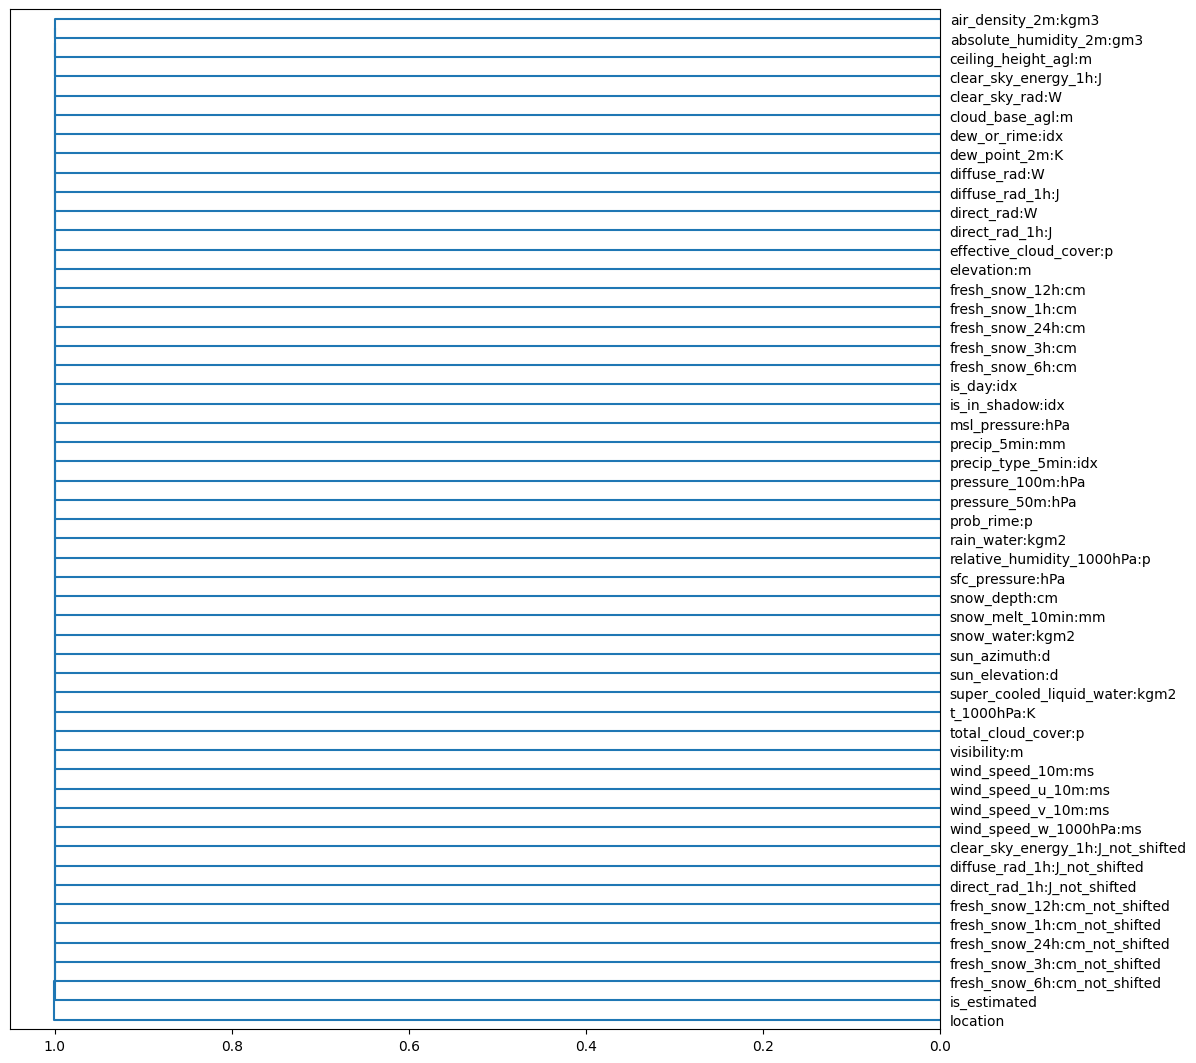

In [47]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=train_data, test_data=test_data, label="y", sample=None)

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,299.128516,787.495283,-0.0,0.0,0.0,183.7125,5596.36,float64,2419,,,float,


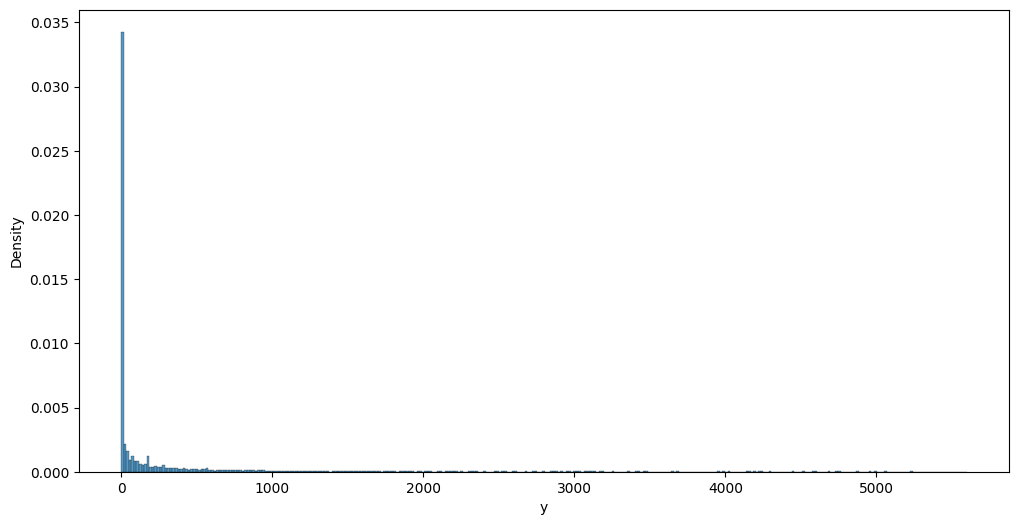

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `y` >= `0.5` (sample size: 10000)**

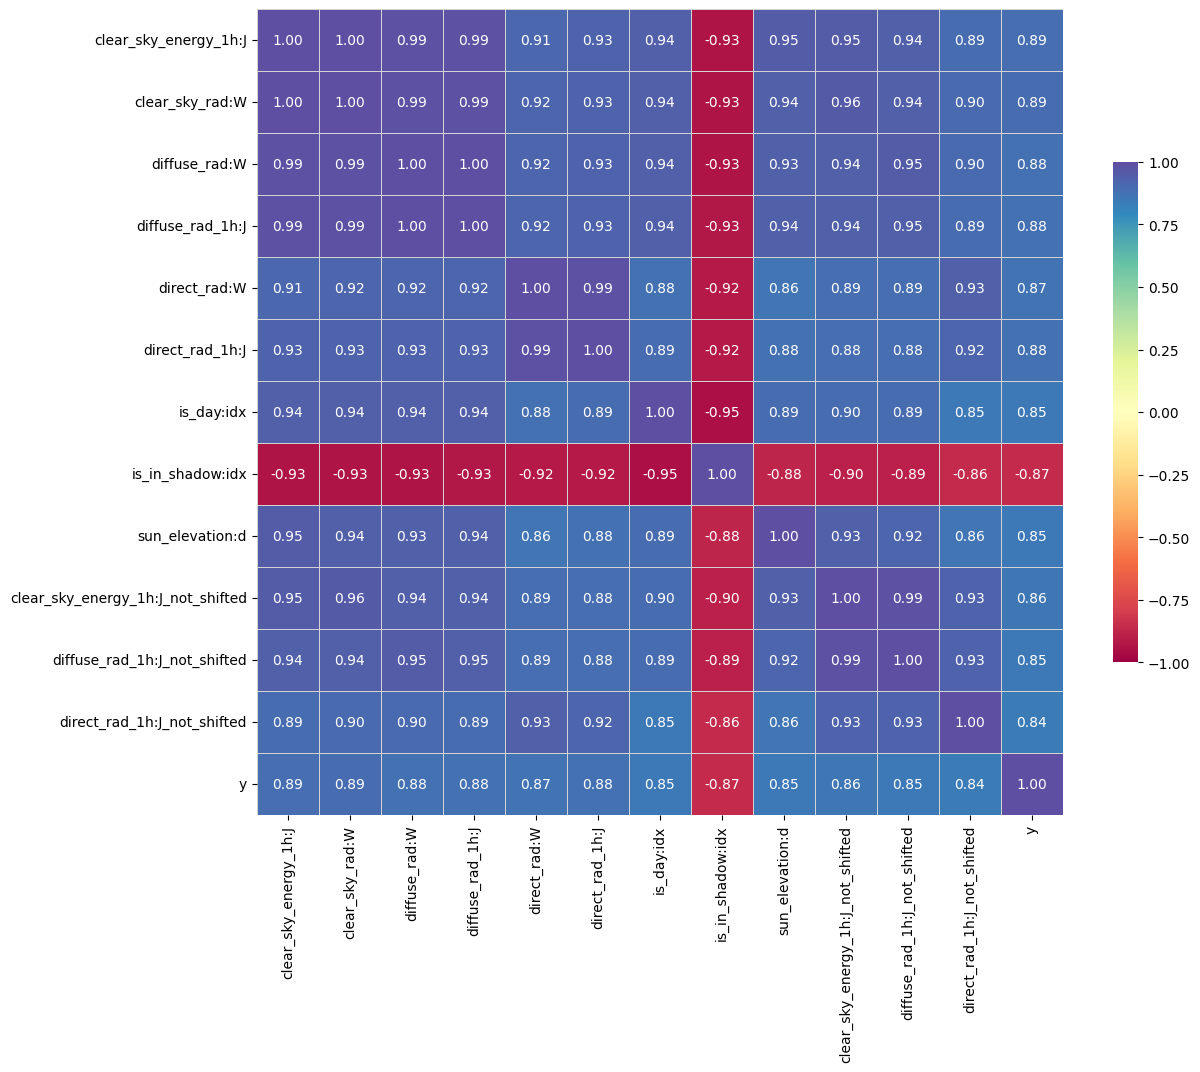

**Feature interaction between `clear_sky_rad:W`/`y` in `train_data` (sample size: 10000)**

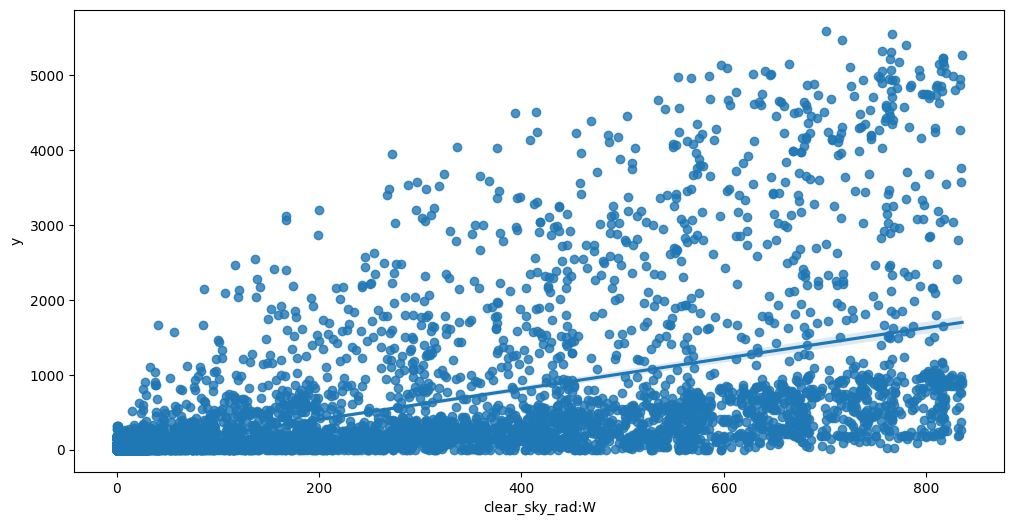

**Feature interaction between `clear_sky_energy_1h:J`/`y` in `train_data` (sample size: 10000)**

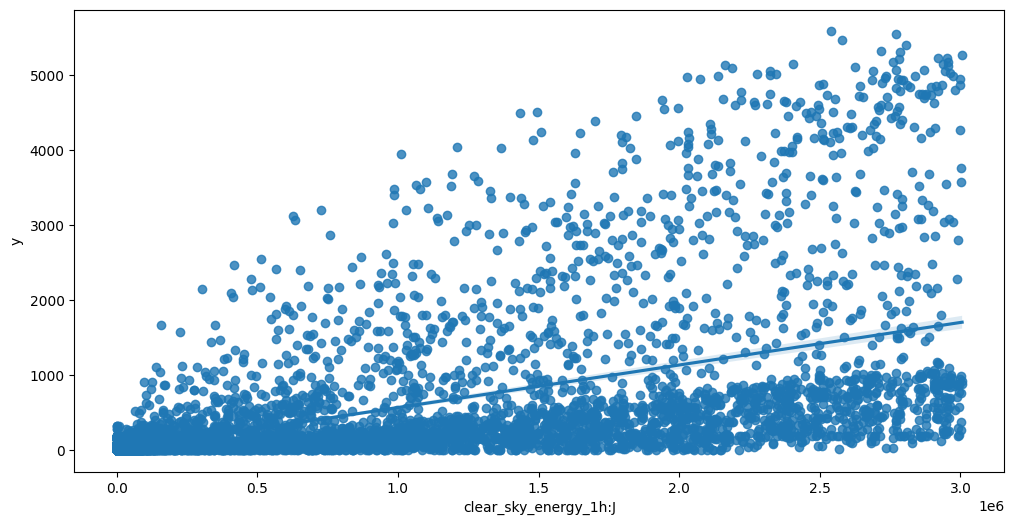

**Feature interaction between `diffuse_rad:W`/`y` in `train_data` (sample size: 10000)**

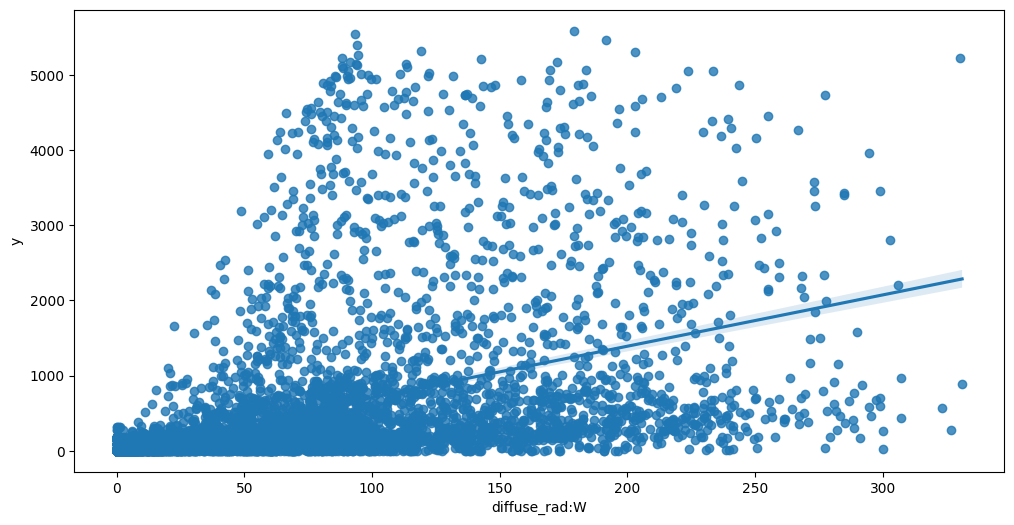

**Feature interaction between `diffuse_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

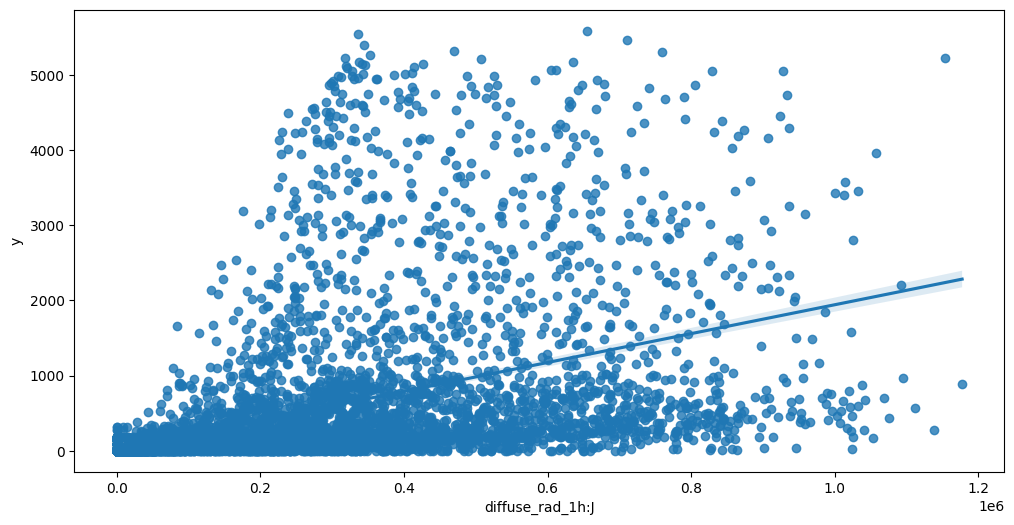

**Feature interaction between `direct_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

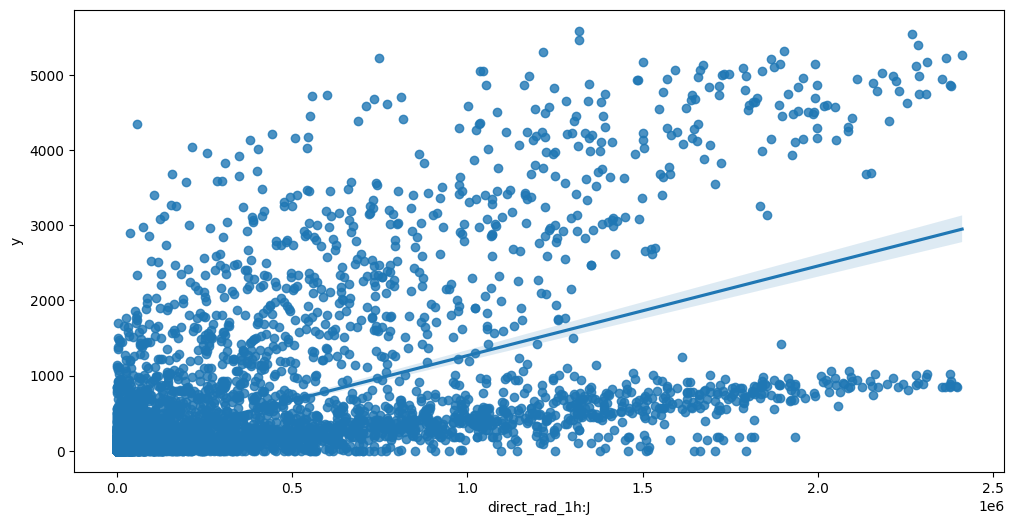

**Feature interaction between `direct_rad:W`/`y` in `train_data` (sample size: 10000)**

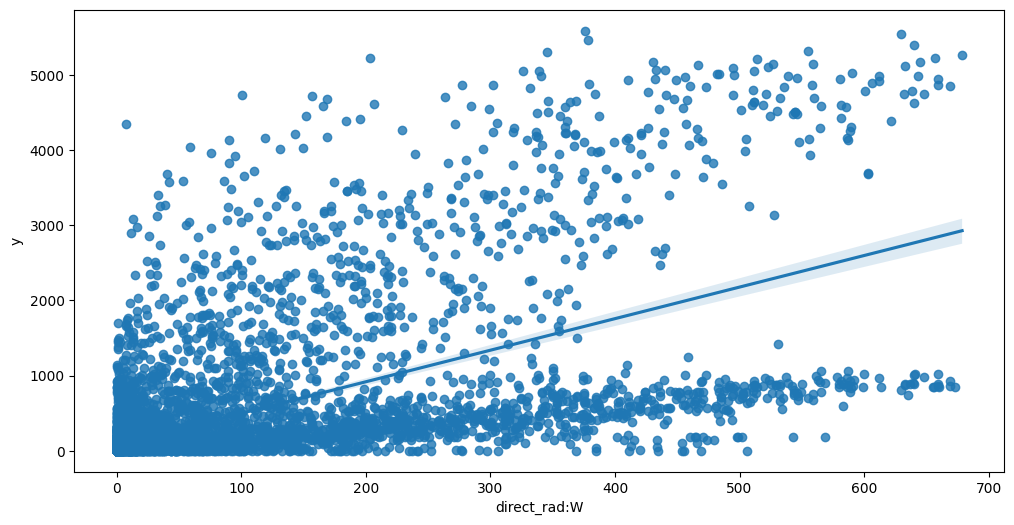

**Feature interaction between `clear_sky_energy_1h:J_not_shifted`/`y` in `train_data` (sample size: 10000)**

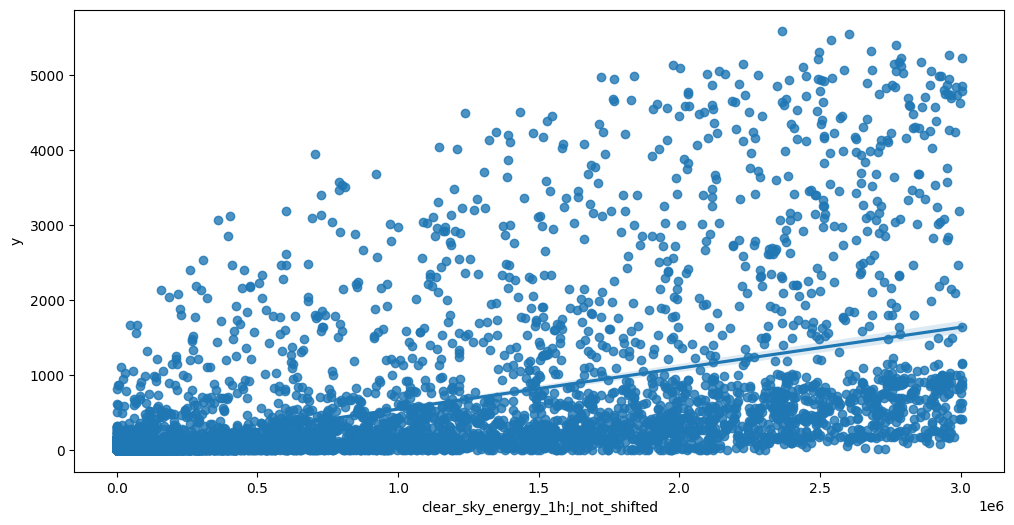

**Feature interaction between `sun_elevation:d`/`y` in `train_data` (sample size: 10000)**

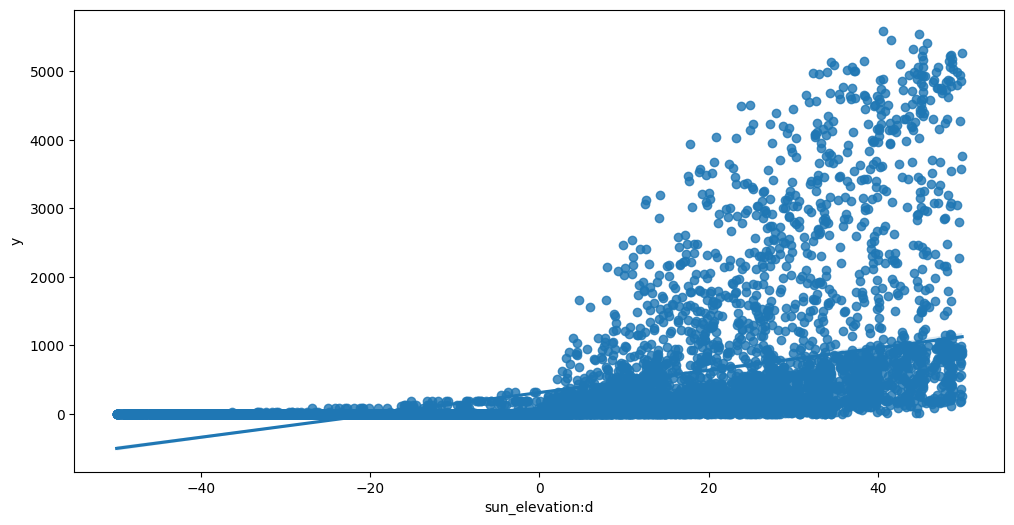

**Feature interaction between `diffuse_rad_1h:J_not_shifted`/`y` in `train_data` (sample size: 10000)**

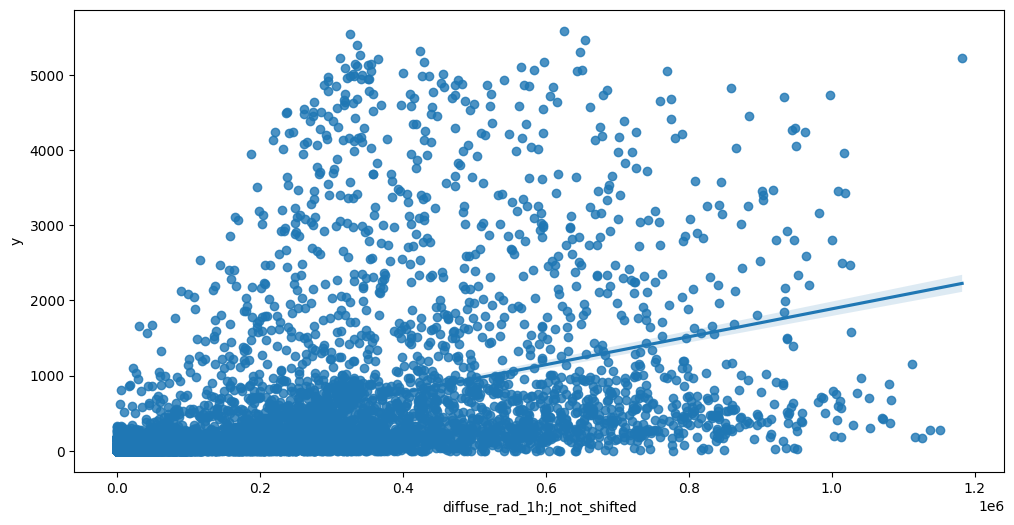

**Feature interaction between `is_day:idx`/`y` in `train_data` (sample size: 10000)**

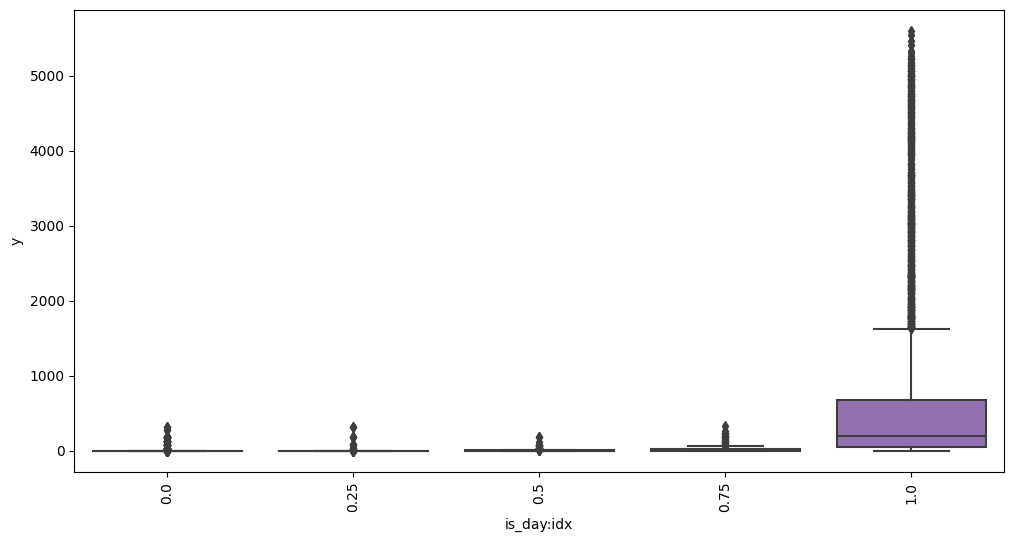

**Feature interaction between `direct_rad_1h:J_not_shifted`/`y` in `train_data` (sample size: 10000)**

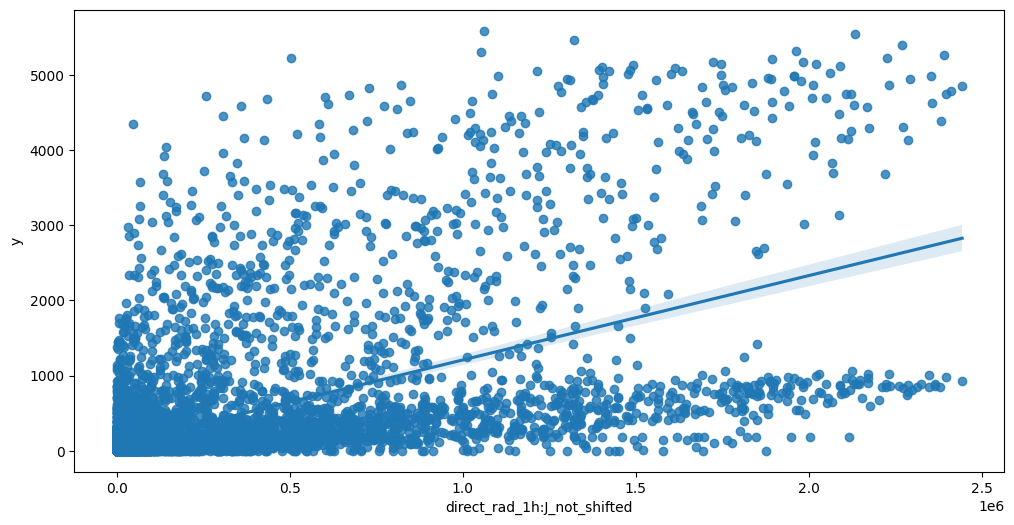

**Feature interaction between `is_in_shadow:idx`/`y` in `train_data` (sample size: 10000)**

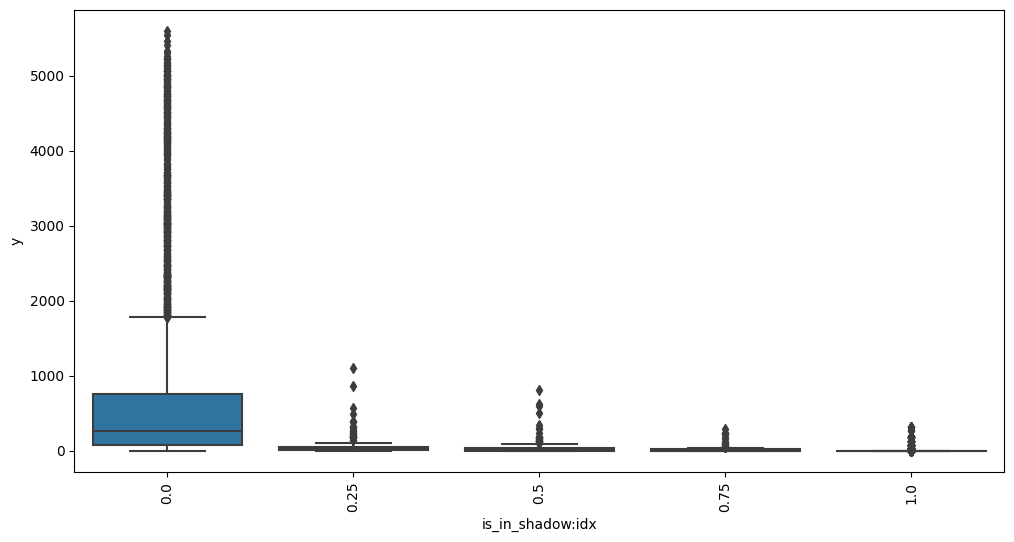

In [48]:
if run_analysis:
    auto.target_analysis(train_data=train_data, label="y")

# Starting

In [49]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 83
Now creating submission number: 84
New filename: submission_84_jorge


In [50]:
predictors = [None, None, None]

In [51]:
def fit_predictor_for_location(loc):
    print(f"Training model for location {loc}...")
    # sum of sample weights for this location, and number of rows, for both train and tune data and test data
    print("Train data sample weight sum:", train_data[train_data["location"] == loc]["sample_weight"].sum())
    print("Train data number of rows:", train_data[train_data["location"] == loc].shape[0])
    if use_tune_data:
        print("Tune data sample weight sum:", tuning_data[tuning_data["location"] == loc]["sample_weight"].sum())
        print("Tune data number of rows:", tuning_data[tuning_data["location"] == loc].shape[0])
    if use_test_data:
        print("Test data sample weight sum:", test_data[test_data["location"] == loc]["sample_weight"].sum())
        print("Test data number of rows:", test_data[test_data["location"] == loc].shape[0])
    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
        sample_weight=sample_weight, 
        weight_evaluation=weight_evaluation, 
        groups="group" if use_groups else None,
    ).fit(
        train_data=train_data[train_data["location"] == loc],
        time_limit=time_limit, 
        presets=presets, 
        num_stack_levels=num_stack_levels, 
        num_bag_folds=num_bag_folds if not use_groups else 2,# just put somethin, will be overwritten anyways
        tuning_data=tuning_data[tuning_data["location"] == loc] if use_tune_data else None,
        use_bag_holdout=use_bag_holdout,
        holdout_frac=holdout_frac,
    )

    # evaluate on test data
    if use_test_data:
        # drop sample_weight column
        t = test_data[test_data["location"] == loc]#.drop(columns=["sample_weight"])
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "AutogluonModels/submission_84_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   10.64 GB / 494.38 GB (2.2%)


Train Data Rows:    31924
Train Data Columns: 54
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 632.68576, 1165.32372)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4468.53 MB
	Train Data (Original)  Memory Usage: 15.39 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique value

Training model for location A...
Train data sample weight sum: 31924
Train data number of rows: 31924
Test data sample weight sum: 2161
Test data number of rows: 2161


AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 79.89s of the 119.85s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 385.95s compared to 103.82s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 73.78s of the 113.75s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 294.08s compared to 95.88s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 69.12s of the 109.08s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 816. Best iteration is:
	[816]	valid_set's l1: 177.763
	Ran out of time, early stoppin

[1000]	valid_set's l1: 168.676


	Ran out of time, early stopping on iteration 1106. Best iteration is:
	[1104]	valid_set's l1: 167.819


[1000]	valid_set's l1: 170.741


	Ran out of time, early stopping on iteration 1235. Best iteration is:
	[1234]	valid_set's l1: 169.234


[1000]	valid_set's l1: 162.709


	Ran out of time, early stopping on iteration 1463. Best iteration is:
	[1462]	valid_set's l1: 159.251
	-169.6153	 = Validation score   (-mean_absolute_error)
	65.8s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 2.46s of the 42.43s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's l1: 601.726
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's l1: 590.67
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's l1: 521.229
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's l1: 527.409
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's l1: 502.007
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's l1: 489.177
	Ran ou

Evaluation on test data:
-185.98676498176297


In [52]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "AutogluonModels/submission_84_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   10.08 GB / 494.38 GB (2.0%)
Train Data Rows:    30792
Train Data Columns: 54
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 97.67477, 195.03642)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary',

Training model for location B...
Train data sample weight sum: 30792
Train data number of rows: 30792
Test data sample weight sum: 2051
Test data number of rows: 2051


		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 51 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 50 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', ['bool']) :  2 | ['elevation:m', 'is_estimated']
	0.2s = Fit runtime
	52 features in original data used to generate 52 features in processed data.
	Train Data (Processed) Memory Usage: 12.38 MB (0.3% of available memory)
Data preprocessing and feature engineering runtime = 0.18s ...
AutoGluon will gauge pr

[1000]	valid_set's l1: 34.551


	Ran out of time, early stopping on iteration 1057. Best iteration is:
	[1057]	valid_set's l1: 34.3819


[1000]	valid_set's l1: 34.9428


	Ran out of time, early stopping on iteration 1082. Best iteration is:
	[1082]	valid_set's l1: 34.6931


[1000]	valid_set's l1: 34.4455


	Ran out of time, early stopping on iteration 1075. Best iteration is:
	[1070]	valid_set's l1: 34.2531
	Ran out of time, early stopping on iteration 967. Best iteration is:
	[966]	valid_set's l1: 35.6559


[1000]	valid_set's l1: 35.3143


	Ran out of time, early stopping on iteration 1092. Best iteration is:
	[1092]	valid_set's l1: 35.0572


[1000]	valid_set's l1: 33.6743


	Ran out of time, early stopping on iteration 1162. Best iteration is:
	[1154]	valid_set's l1: 33.1587


[1000]	valid_set's l1: 32.9503


	Ran out of time, early stopping on iteration 1252. Best iteration is:
	[1252]	valid_set's l1: 32.3482


[1000]	valid_set's l1: 33.4977


	Ran out of time, early stopping on iteration 1397. Best iteration is:
	[1397]	valid_set's l1: 32.6614
	-34.0262	 = Validation score   (-mean_absolute_error)
	70.71s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 2.62s of the 42.58s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's l1: 91.0808
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's l1: 94.5272
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's l1: 84.5351
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's l1: 86.4865
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's l1: 84.7282
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's l1: 79.7384
	Ran

Evaluation on test data:
-34.91979680126256


In [53]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "AutogluonModels/submission_84_jorge_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   9.64 GB / 494.38 GB (1.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    24516
Train Data Columns: 54
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 78.04527, 167.43618)
	If 'regression' is not the correct problem_type, please manually specify the p

Training model for location C...
Train data sample weight sum: 24516
Train data number of rows: 24516
Test data sample weight sum: 1579
Test data number of rows: 1579


		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 51 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 50 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', ['bool']) :  2 | ['elevation:m', 'is_estimated']
	0.1s = Fit runtime
	52 features in original data used to generate 52 features in processed data.
	Train Data (Processed) Memory Usage: 9.86 MB (0.2% of available memory)
Data preprocessing and feature engineering runtime = 0.17s ...
AutoGluon will gauge pre

[1000]	valid_set's l1: 19.4005
[1000]	valid_set's l1: 16.6095


	Ran out of time, early stopping on iteration 1056. Best iteration is:
	[1056]	valid_set's l1: 16.5479


[1000]	valid_set's l1: 17.8956


	Ran out of time, early stopping on iteration 1142. Best iteration is:
	[1142]	valid_set's l1: 17.7598


[1000]	valid_set's l1: 19.2446


	Ran out of time, early stopping on iteration 1238. Best iteration is:
	[1238]	valid_set's l1: 18.9869


[1000]	valid_set's l1: 18.9833


	Ran out of time, early stopping on iteration 1290. Best iteration is:
	[1290]	valid_set's l1: 18.6161


[1000]	valid_set's l1: 17.2945


	Ran out of time, early stopping on iteration 1344. Best iteration is:
	[1343]	valid_set's l1: 17.0103


[1000]	valid_set's l1: 18.8137


# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 48 / 48 | Rows = 93023 -> 93023
Loaded data from: X_test_raw.csv | Columns = 47 / 47 | Rows = 4608 -> 4608


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    past_pred = predictors[i].predict(train_data_with_dates[train_data_with_dates["location"] == loc])
    train_data_with_dates.loc[train_data_with_dates["location"] == loc, "prediction"] = past_pred
    

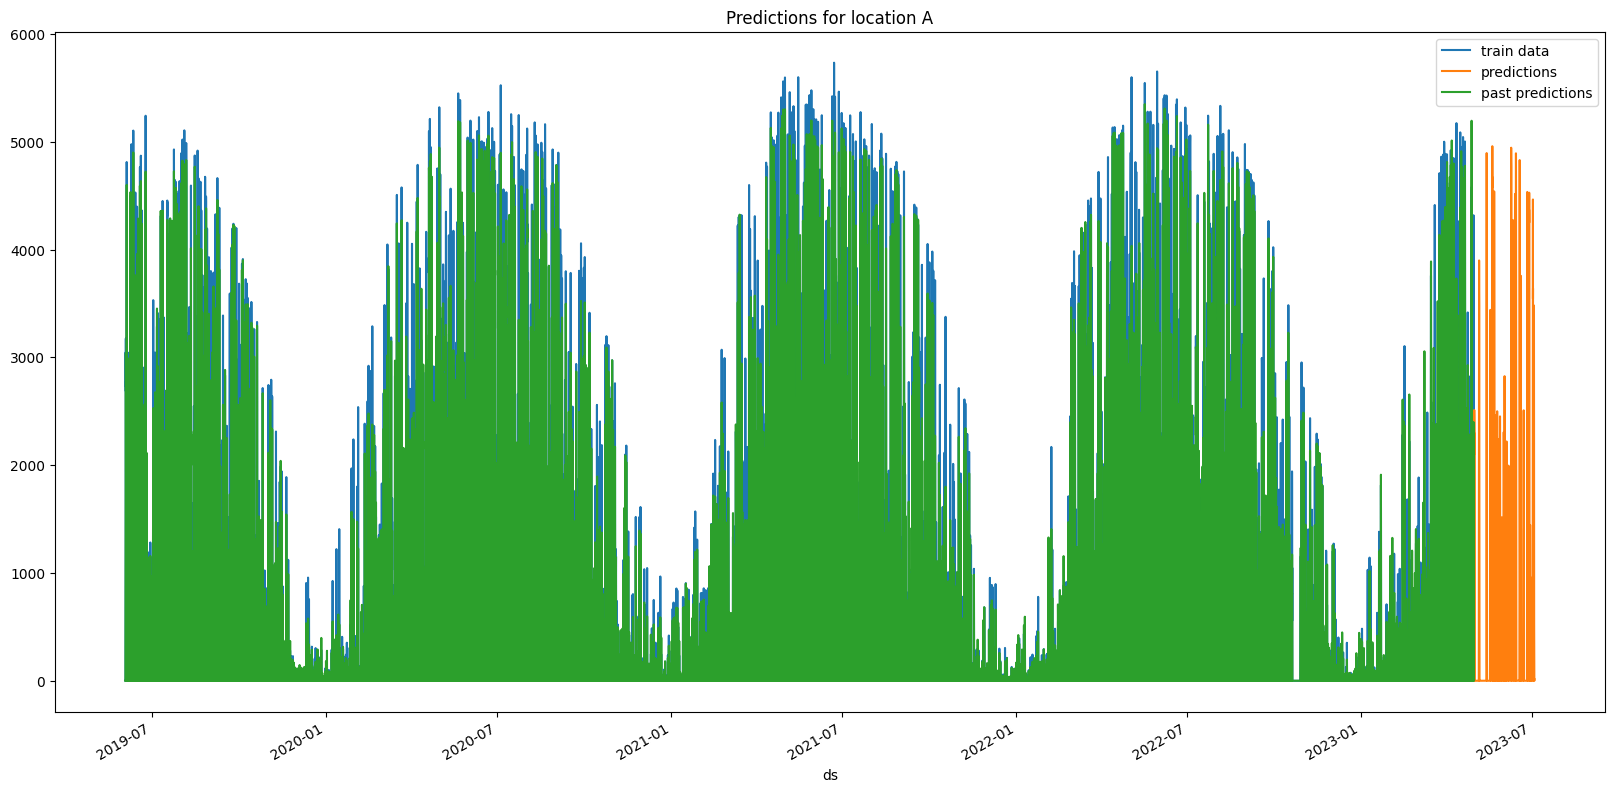

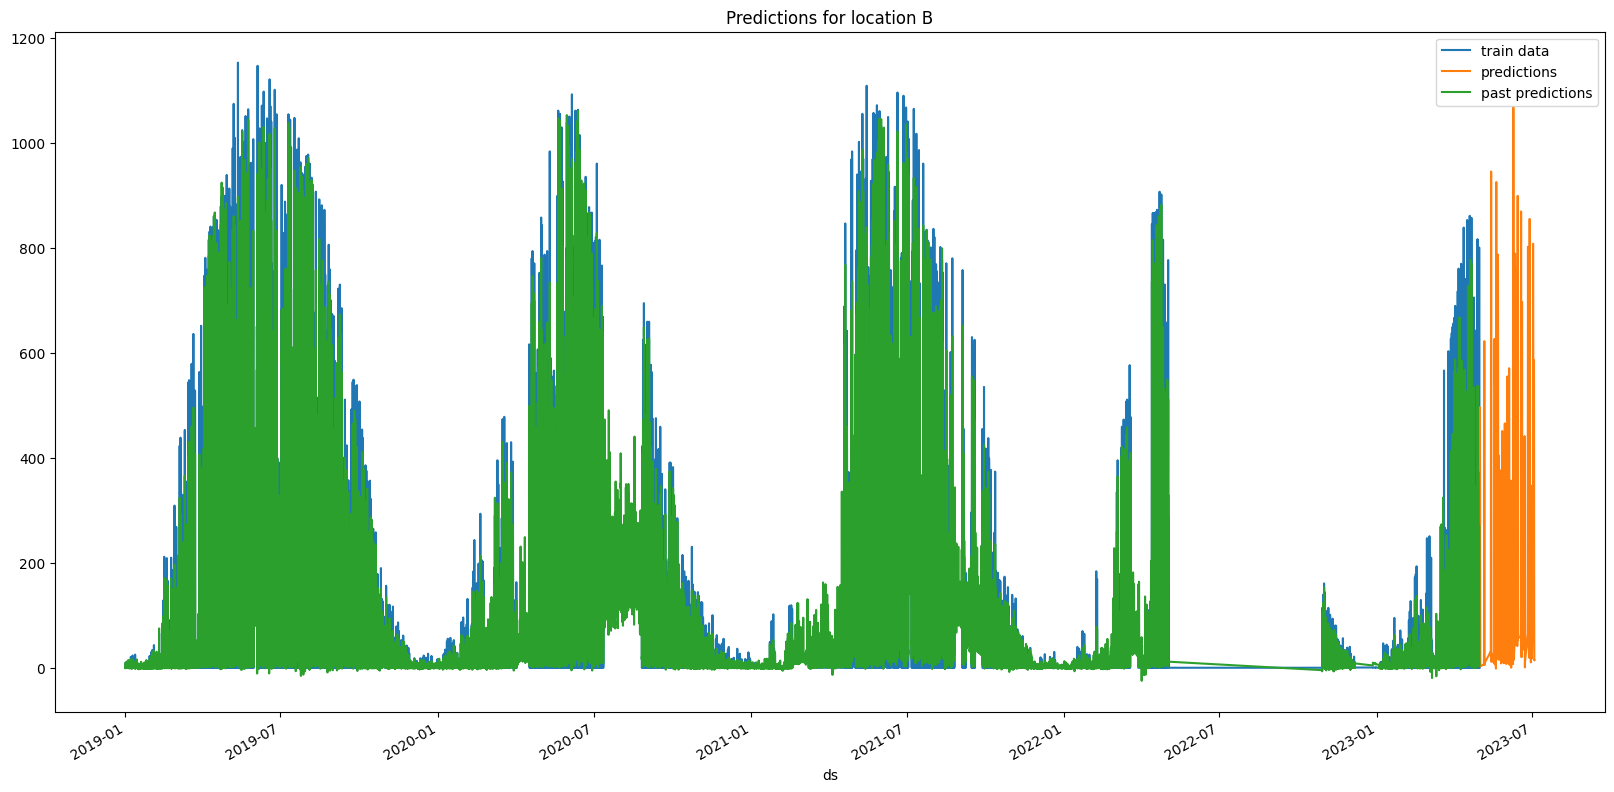

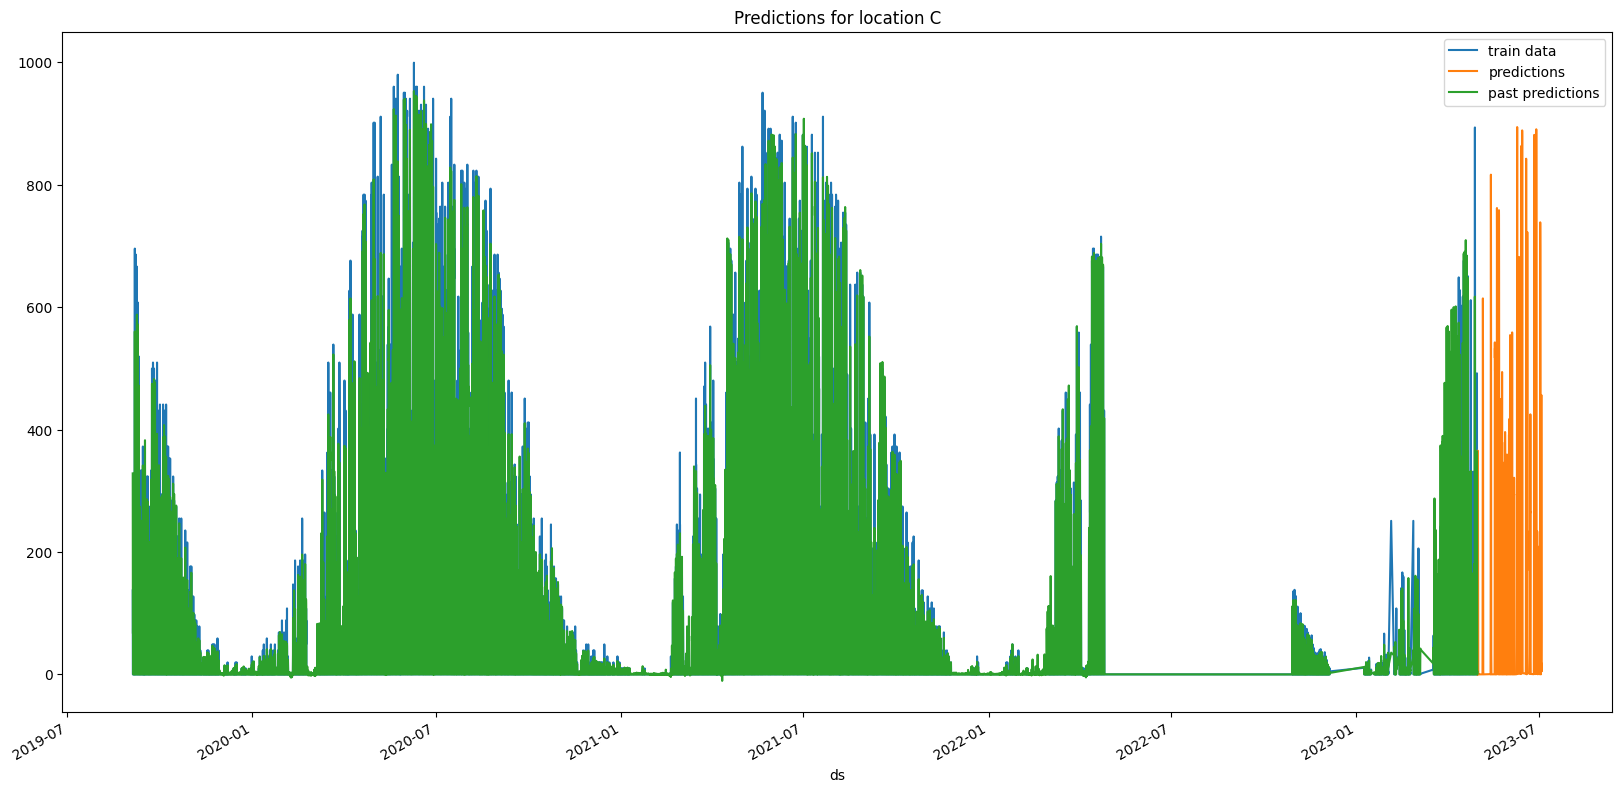

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,0.286531
1,1,0.293899
2,2,0.302308
3,3,68.643791
4,4,431.183838
...,...,...
715,2155,50.653511
716,2156,34.018303
717,2157,11.374412
718,2158,5.061585


In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

Saving submission to submissions/submission_83_jorge.csv
jall1a


In [ ]:
# save this running notebook
from IPython.display import display, Javascript
import time

# hei123

display(Javascript("IPython.notebook.save_checkpoint();"))

time.sleep(3)

<IPython.core.display.Javascript object>

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_83_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_83_jorge_files/notebook_pdfs
[NbConvertApp] Writing 212528 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1483538 bytes to notebook_pdfs/submission_83_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_83_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'sample_weight', 'location', 'prediction']
Computing feature importance via permutation shuffling for 44 features using 4418 rows with 10 shuffle sets... Time limit: 600s...


	449.53s	= Expected runtime (44.95s per shuffle set)
	158.2s	= Actual runtime (Completed 10 of 10 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad_1h:J,162.141265,3.740404,1.486671e-16,10,165.985234,158.297296
direct_rad:W,56.833096,2.128914,1.163083e-14,10,59.020956,54.645236
diffuse_rad_1h:J,54.643759,1.652921,1.701300e-15,10,56.342446,52.945072
clear_sky_rad:W,27.790218,1.465784,2.517679e-13,10,29.296587,26.283849
clear_sky_energy_1h:J,26.552260,1.440795,3.248221e-13,10,28.032948,25.071572
diffuse_rad:W,25.451475,0.974657,1.418238e-14,10,26.453119,24.449831
sun_azimuth:d,23.579392,1.948674,1.411926e-11,10,25.582021,21.576763
total_cloud_cover:p,9.884306,1.445250,2.274824e-09,10,11.369573,8.399039
cloud_base_agl:m,6.226371,0.625761,8.115680e-11,10,6.869458,5.583283
wind_speed_u_10m:ms,6.188929,1.169179,2.167947e-08,10,7.390480,4.987377


In [ ]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'sample_weight', 'location', 'prediction']
Computing feature importance via permutation shuffling for 44 features using 5000 rows with 10 shuffle sets... Time limit: 600s...
	456.05s	= Expected runtime (45.61s per shuffle set)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # feature importance                                                                         │
│   2 observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]                   │
│   3 observed = observed[observed["location"] == location]                                        │
│ ❱ 4 predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*     │
│   5                                                                                              │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/predictor/predict │
│ or.py:2425 in feature_importance                                                                 │
│                                                                                                  │
│   2422 │   │   if num_shuffle_sets is None:                                                      │
│   2423 │   │   │   num_shuffle_sets = 10 if time_limit else 5                                    │
│   2424 │   │                                                                                     │
│ ❱ 2425 │   │   fi_df = self._learner.get_feature_importance(                                     │
│   2426 │   │   │   model=model,                                                                  │
│   2427 │   │   │   X=data,                                                                       │
│   2428 │   │   │   features=features,                                                            │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/learner/abstract_ │
│ learner.py:870 in get_feature_importance                                                         │
│                                                                                                  │
│    867 │   │   │   │   X = X.drop(columns=unused_features)                                       │
│    868 │   │   │                                                                                 │
│    869 │   │   │   if feature_stage == "original":                                               │
│ ❱  870 │   │   │   │   return trainer._get_feature_importance_raw(                               │
│    871 │   │   │   │   │   model=model, X=X, y=y, features=features, subsample_size=subsample_s  │
│    872 │   │   │   │   )                                                                         │
│    873 │   │   │   X = self.transform_features(X)                                                │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/trainer/abstract_tra │
│ iner.py:2574 in _get_feature_importance_raw                                                      │
│                                                                                                  │
│   2571 │   │   │   predict_func = self.predict_proba                                             │
│   2572 │   │   model: AbstractModel = self.load_model(model)                                     │
│   2573 │   │   predict_func_kwargs = dict(model=model)                                           │
│ ❱ 2574 │   │   return compute_permutation_feature_importance(                                    │
│   2575 │   │   │   X=X,                                                                          │
│   2576 │   │   │   y=y,                                    

In [ ]:
display(Javascript("IPython.notebook.save_checkpoint();"))
time.sleep(3)

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/ag/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/jupyter_core/application.py", line 282, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance
    app.start()
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 412, in start
    self.convert_notebooks()
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 590, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 556, in convert_single_notebook
   

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_94_jorge_with_feature_importance.pdf', 'autogluon_each_location.ipynb'], returncode=1)

In [ ]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])